## Neural Network Model to Classify Images

핵심: CIFAR-10 이미지(32x32x3)를 분류하는 MLP와 CNN 파이프라인을 구축하고 비교한다.

구성: 환경 설정 → 데이터 로딩/전처리 → MLP 구축/학습/평가 → CNN 구축/학습/평가 → 비교/오류분석 → 모델 저장/불러오기.

In [2]:
# 환경 확인
import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

# TensorFlow/Keras 버전 확인
import tensorflow as tf
import keras
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

# GPU 확인
print("GPU Available:", tf.config.list_physical_devices('GPU'))


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
TensorFlow: 2.19.0
Keras: 3.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


재현성을 위해 시드를 고정하고, 시각화/분석 도구를 임포트한다.

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

CIFAR-10은 10개 클래스, 50k 학습/10k 테스트로 구성된 표준 이미지 분류 데이터셋이다.

/tmp/ipython-input-3657109938.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[i])])


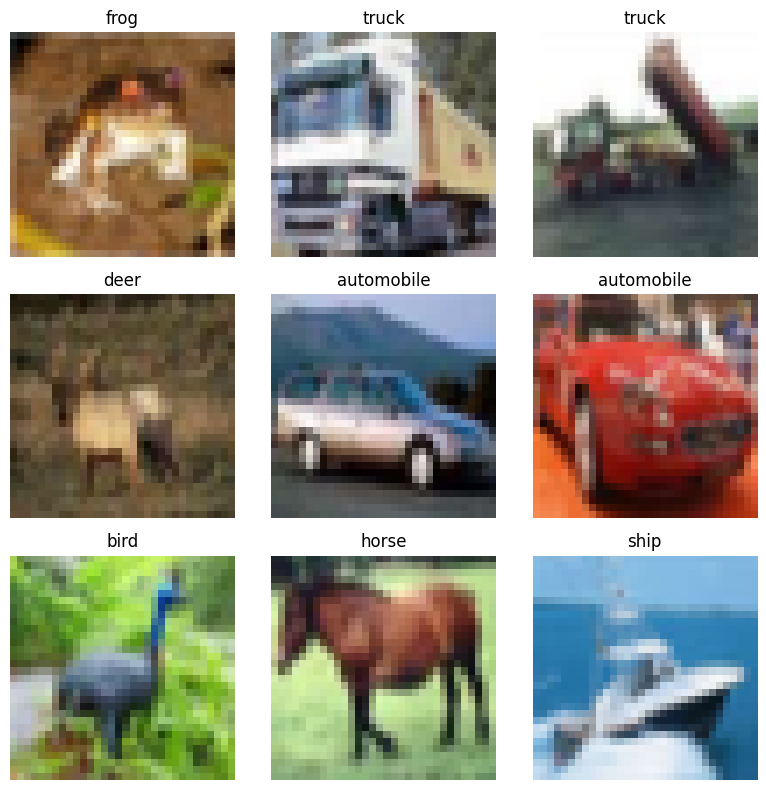

In [4]:
class_names = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


데이터 분포 감을 얻기 위해 몇 개의 이미지를 시각화한다.

In [6]:
# 스케일링
x_train_f = x_train.astype("float32") / 255.0
x_test_f  = x_test.astype("float32") / 255.0

# 라벨 원-핫
y_train_c = keras.utils.to_categorical(y_train, num_classes)
y_test_c  = keras.utils.to_categorical(y_test, num_classes)

# 데이터 증강 레이어(CNN용)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

픽셀 값을 스케일링하고, 라벨을 원-핫 인코딩한다. CNN에는 데이터 증강을 추가한다.

In [6]:
def build_mlp(input_shape=(32,32,3), num_classes=10, dropout_rate=0.3):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mlp_cifar10")
    return model

mlp = build_mlp()
mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
mlp.summary()


Model: "mlp_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

32x32x3 이미지를 평탄화 후 전결합 층으로 학습하는 간단한 MLP를 구현한다.

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
]

history_mlp = mlp.fit(
    x_train_f, y_train_c,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50
352/352 - 8s - 23ms/step - accuracy: 0.2546 - loss: 2.0408 - val_accuracy: 0.3414 - val_loss: 1.8264 - learning_rate: 1.0000e-03
Epoch 2/50
352/352 - 4s - 12ms/step - accuracy: 0.3116 - loss: 1.8905 - val_accuracy: 0.3458 - val_loss: 1.8166 - learning_rate: 1.0000e-03
Epoch 3/50
352/352 - 1s - 4ms/step - accuracy: 0.3253 - loss: 1.8507 - val_accuracy: 0.3738 - val_loss: 1.7790 - learning_rate: 1.0000e-03
Epoch 4/50
352/352 - 2s - 4ms/step - accuracy: 0.3410 - loss: 1.8125 - val_accuracy: 0.3934 - val_loss: 1.7514 - learning_rate: 1.0000e-03
Epoch 5/50
352/352 - 2s - 6ms/step - accuracy: 0.3474 - loss: 1.7909 - val_accuracy: 0.3962 - val_loss: 1.7310 - learning_rate: 1.0000e-03
Epoch 6/50
352/352 - 1s - 3ms/step - accuracy: 0.3550 - loss: 1.7720 - val_accuracy: 0.4136 - val_loss: 1.7038 - learning_rate: 1.0000e-03
Epoch 7/50
352/352 - 1s - 4ms/step - accuracy: 0.3650 - loss: 1.7531 - val_accuracy: 0.4062 - val_loss: 1.6917 - learning_rate: 1.0000e-03
Epoch 8/50
352/352 - 1s -

기본 학습 설정으로 overfitting을 방지하기 위해 EarlyStopping과 ReduceLROnPlateau를 사용한다.

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_mlp = np.argmax(mlp.predict(x_test_f, verbose=0), axis=1)
y_true = y_test.flatten()
test_loss_mlp, test_acc_mlp = mlp.evaluate(x_test_f, y_test_c, verbose=0)
print("MLP Test Accuracy:", round(test_acc_mlp, 4))

cm_mlp = confusion_matrix(y_true, y_pred_mlp)
print(classification_report(y_true, y_pred_mlp, target_names=class_names))


MLP Test Accuracy: 0.4764
              precision    recall  f1-score   support

    airplane       0.62      0.47      0.53      1000
  automobile       0.64      0.58      0.61      1000
        bird       0.39      0.24      0.29      1000
         cat       0.31      0.41      0.35      1000
        deer       0.40      0.46      0.43      1000
         dog       0.49      0.23      0.31      1000
        frog       0.41      0.66      0.50      1000
       horse       0.57      0.50      0.54      1000
        ship       0.55      0.68      0.61      1000
       truck       0.52      0.54      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.47     10000
weighted avg       0.49      0.48      0.47     10000



테스트 세트 정확도를 확인하고, 오류 패턴을 보기 위해 혼동행렬을 계산한다.

In [9]:
def build_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="cnn_cifar10")

cnn = build_cnn()
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
cnn.summary()


Model: "cnn_cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 141,994 (554.66 KB)

 Trainable params: 141,354 (552.16 KB)

 Non-trainable params: 640 (2.50 KB)

이미지 분류에는 CNN이 더 적합하므로, 현대적 베이스라인(Conv-BN-ReLU + MaxPool, Dropout) 아키텍처를 사용한다.

In [10]:
callbacks_cnn = [
    keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=6, factor=0.5, verbose=1),
]

history_cnn = cnn.fit(
    x_train_f, y_train_c,
    validation_split=0.1,
    epochs=80,
    batch_size=128,
    callbacks=callbacks_cnn,
    verbose=2
)

Epoch 1/80
352/352 - 20s - 57ms/step - accuracy: 0.3985 - loss: 1.6253 - val_accuracy: 0.1948 - val_loss: 2.6217 - learning_rate: 1.0000e-03
Epoch 2/80
352/352 - 14s - 39ms/step - accuracy: 0.5176 - loss: 1.3302 - val_accuracy: 0.4978 - val_loss: 1.3889 - learning_rate: 1.0000e-03
Epoch 3/80
352/352 - 10s - 28ms/step - accuracy: 0.5638 - loss: 1.2115 - val_accuracy: 0.5826 - val_loss: 1.1775 - learning_rate: 1.0000e-03
Epoch 4/80
352/352 - 10s - 27ms/step - accuracy: 0.5952 - loss: 1.1342 - val_accuracy: 0.5818 - val_loss: 1.2805 - learning_rate: 1.0000e-03
Epoch 5/80
352/352 - 10s - 30ms/step - accuracy: 0.6150 - loss: 1.0813 - val_accuracy: 0.5934 - val_loss: 1.3006 - learning_rate: 1.0000e-03
Epoch 6/80
352/352 - 10s - 29ms/step - accuracy: 0.6354 - loss: 1.0293 - val_accuracy: 0.6092 - val_loss: 1.2250 - learning_rate: 1.0000e-03
Epoch 7/80
352/352 - 9s - 27ms/step - accuracy: 0.6490 - loss: 0.9920 - val_accuracy: 0.5396 - val_loss: 1.5384 - learning_rate: 1.0000e-03
Epoch 8/80
352

동일한 콜백으로 학습하며, 데이터 증강이 내장되어 일반화 성능을 높인다.

In [11]:
y_pred_cnn = np.argmax(cnn.predict(x_test_f, verbose=0), axis=1)
test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test_f, y_test_c, verbose=0)
print("CNN Test Accuracy:", round(test_acc_cnn, 4))

cm_cnn = confusion_matrix(y_true, y_pred_cnn)
print(classification_report(y_true, y_pred_cnn, target_names=class_names))


CNN Test Accuracy: 0.8057
              precision    recall  f1-score   support

    airplane       0.83      0.81      0.82      1000
  automobile       0.89      0.93      0.91      1000
        bird       0.76      0.72      0.74      1000
         cat       0.79      0.56      0.65      1000
        deer       0.78      0.78      0.78      1000
         dog       0.82      0.66      0.73      1000
        frog       0.66      0.94      0.78      1000
       horse       0.83      0.86      0.85      1000
        ship       0.88      0.89      0.88      1000
       truck       0.86      0.92      0.89      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



테스트 정확도와 분류 리포트를 통해 MLP 대비 성능 향상을 확인한다.

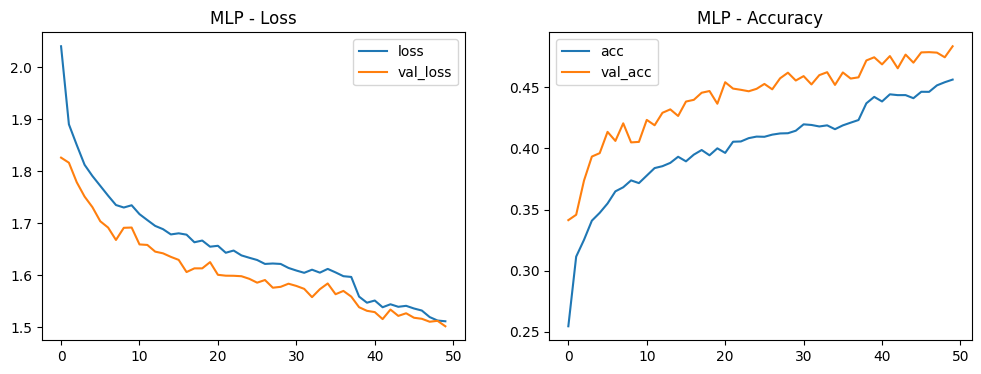

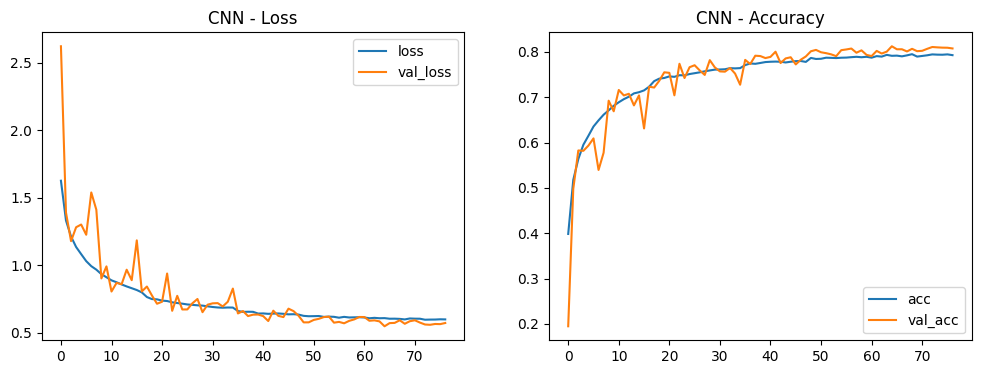

In [12]:
def plot_history(h, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

plot_history(history_mlp, "MLP")
plot_history(history_cnn, "CNN")


손실/정확도 곡선을 통해 과적합 여부와 학습 안정성을 비교한다.

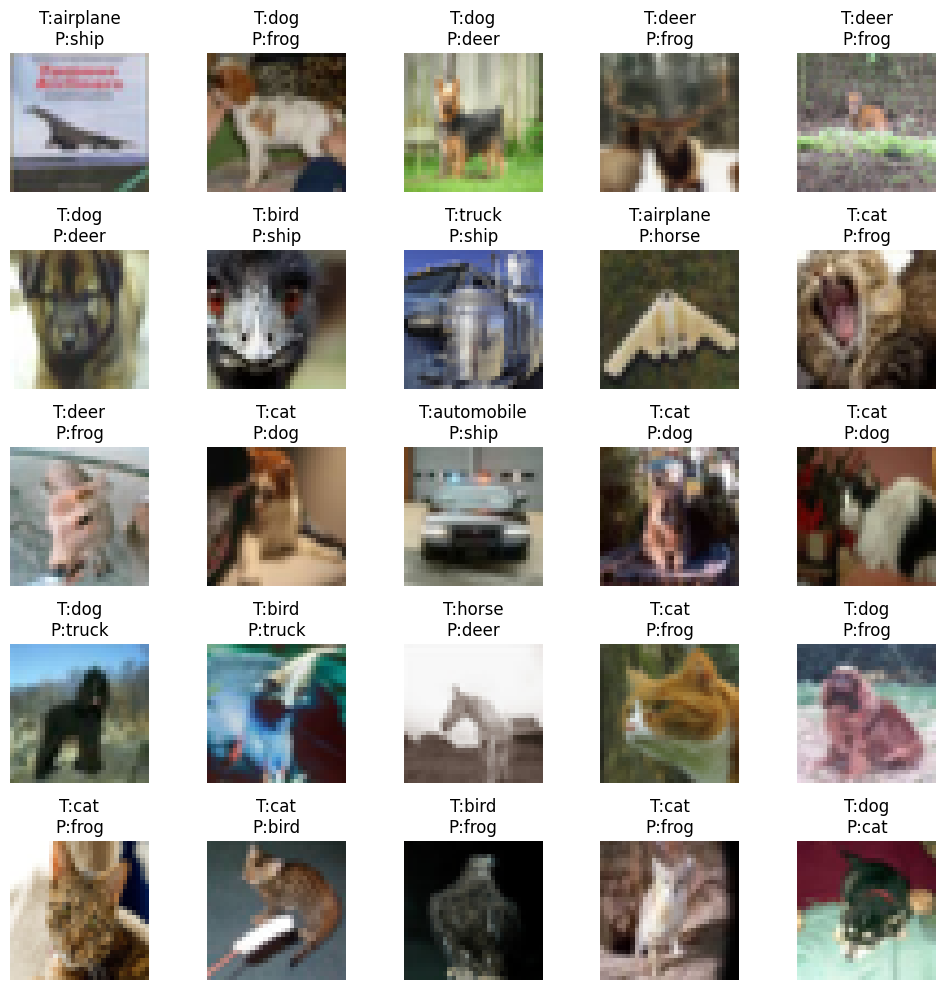

In [14]:
mis_idx = np.where(y_pred_cnn != y_true)[0][:25]
plt.figure(figsize=(10,10))
for i, idx in enumerate(mis_idx):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[idx])
    plt.title(f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred_cnn[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

오류 사례를 시각적으로 검토해 모델 개선 포인트를 찾는다.

In [15]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
mlp.save(os.path.join(save_dir, "mlp_cifar10.keras"))
cnn.save(os.path.join(save_dir, "cnn_cifar10.keras"))

# 로드 예시
mlp_loaded = keras.models.load_model(os.path.join(save_dir, "mlp_cifar10.keras"))
cnn_loaded = keras.models.load_model(os.path.join(save_dir, "cnn_cifar10.keras"))
print("Loaded models:", mlp_loaded.name, cnn_loaded.name)


Loaded models: mlp_cifar10 cnn_cifar10


Keras SavedModel 형식으로 저장하고 재사용할 수 있도록 한다.

In [18]:
def predict_single_image(model, img_array, class_names):
    # img_array: (H,W,3) uint8 or float
    if img_array.dtype != np.float32 and img_array.dtype != np.float64:
        img = img_array.astype("float32") / 255.0
    else:
        img = img_array
    img = np.expand_dims(img, axis=0)
    probs = model.predict(img, verbose=0)
    pred_idx = int(np.argmax(probs))
    return class_names[pred_idx], probs

# Create a CNN model for prediction without the data augmentation layer
cnn_predict = keras.Model(inputs=cnn.layers[1].input, outputs=cnn.output)


# 예시: 테스트 셋에서 1장
img_index = 0 # Change this index to test different images
pred_label, probs = predict_single_image(cnn_predict, x_test[img_index], class_names)
true_label = class_names[int(y_test[img_index])]

print(f"True Label: {true_label}")
print(f"Predicted Label: {pred_label}")
print(f"Prediction Probability: {np.max(probs):.4f}")

True Label: cat
Predicted Label: cat
Prediction Probability: 0.8095


/tmp/ipython-input-2297741382.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = class_names[int(y_test[img_index])]


외부 이미지나 테스트 이미지에서 단일 추론을 쉽게 수행한다.

In [7]:
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input as eff_pre
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        self.times.append(epoch_time)
        elapsed_time = time.time() - self.start_time
        if epoch > 0:
            avg_epoch_time = elapsed_time / (epoch + 1)
            remaining_epochs = self.params['epochs'] - (epoch + 1)
            remaining_time = avg_epoch_time * remaining_epochs
            print(f"Epoch {epoch+1}/{self.params['epochs']} - Time: {epoch_time:.2f}s, Elapsed: {elapsed_time:.2f}s, Estimated Remaining: {remaining_time:.2f}s")
        else:
            print(f"Epoch {epoch+1}/{self.params['epochs']} - Time: {epoch_time:.2f}s, Elapsed: {elapsed_time:.2f}s")


def build_transfer(input_shape=(32,32,3), target_size=(224,224), num_classes=10, train_base=False):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(target_size[0], target_size[1], 3))
    base.trainable = train_base
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Resizing(target_size[0], target_size[1])(x) # Apply resizing here
    x = layers.Lambda(eff_pre)(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="effnetb0_transfer")

# No need to pre-resize the entire dataset
# resize_layer = layers.Resizing(224,224)
# x_train_r = resize_layer(x_train_f).numpy()
# x_test_r  = resize_layer(x_test_f).numpy()

transfer = build_transfer() # Use default input_shape=(32,32,3)
transfer.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="categorical_crossentropy", metrics=["accuracy"])
hist_transfer = transfer.fit(
    x_train_f, y_train_c, # Use original scaled data
    validation_split=0.1,
    epochs=10, # Reduced epochs for faster training
    batch_size=256, # Increased batch size for faster training
    callbacks=[
        TimeHistory(), # Add time tracking callback
        keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ],
    verbose=1 # Changed verbose to 1 to show progress bar
)
test_loss_t, test_acc_t = transfer.evaluate(x_test_f, y_test_c, verbose=0) # Use original scaled data for evaluation
print("Transfer Test Accuracy:", round(test_acc_t, 4))

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.1006 - loss: 2.3269Epoch 1/10 - Time: 112.96s, Elapsed: 112.97s
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 563ms/step - accuracy: 0.1006 - loss: 2.3269 - val_accuracy: 0.0958 - val_loss: 2.3058 - learning_rate: 0.0010
Epoch 2/10
 56/176 ━━━━━━━━━━━━━━━━━━━━ 57s 477ms/step - accuracy: 0.0989 - loss: 2.3191

KeyboardInterrupt: 

더 높은 성능을 위해 EfficientNetB0 같은 경량 사전학습 백본을 사용한 전이학습을 제공한다.

하지만 너무 많은 시간이 걸리면서 성능도 낮아보인다.

In [8]:
# Rebuild the model with the same structure as the previous successful training run (Resizing before Lambda)
# and enable fine-tuning
def build_transfer_finetune(input_shape=(32,32,3), target_size=(224,224), num_classes=10, train_base=True, fine_tune_at=100):
    base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(target_size[0], target_size[1], 3))

    # Unfreeze layers starting from `fine_tune_at`
    if train_base:
      base.trainable = True
      for layer in base.layers[:fine_tune_at]:
          layer.trainable = False
    else:
      base.trainable = False


    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Resizing(target_size[0], target_size[1])(x)
    x = layers.Lambda(eff_pre)(x)
    x = base(x, training=train_base) # Set training=train_base
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="effnetb0_transfer_finetune")

# Build and compile the fine-tuned model
transfer_finetune = build_transfer_finetune(train_base=True, fine_tune_at=150) # Fine-tune later layers

transfer_finetune.compile(optimizer=keras.optimizers.Adam(1e-4), # Use a smaller learning rate
                 loss="categorical_crossentropy", metrics=["accuracy"])

transfer_finetune.summary()

Model: "effnetb0_transfer_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 3,300,514 (12.59 MB)

 Non-trainable params: 761,867 (2.91 MB)

In [9]:
# Train the fine-tuned model
hist_transfer_finetune = transfer_finetune.fit(
    x_train_f, y_train_c,
    validation_split=0.1,
    epochs=20, # Increase epochs
    batch_size=128,
    callbacks=[
        TimeHistory(),
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_accuracy"), # Increased patience
        keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1), # Increased patience
    ],
    verbose=1
)

# Evaluate the fine-tuned model
test_loss_t_finetune, test_acc_t_finetune = transfer_finetune.evaluate(x_test_f, y_test_c, verbose=0)
print("Transfer (Finetuned) Test Accuracy:", round(test_acc_t_finetune, 4))

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.1340 - loss: 2.2777Epoch 1/20 - Time: 179.49s, Elapsed: 179.50s
352/352 ━━━━━━━━━━━━━━━━━━━━ 180s 450ms/step - accuracy: 0.1341 - loss: 2.2774 - val_accuracy: 0.1102 - val_loss: 2.3669 - learning_rate: 1.0000e-04
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.2484 - loss: 1.9867Epoch 2/20 - Time: 145.12s, Elapsed: 324.85s, Estimated Remaining: 2923.68s
352/352 ━━━━━━━━━━━━━━━━━━━━ 145s 412ms/step - accuracy: 0.2484 - loss: 1.9866 - val_accuracy: 0.1418 - val_loss: 3.0792 - learning_rate: 1.0000e-04
Epoch 3/20


KeyboardInterrupt: 

Fine tuning 해도 마찬가지.

다른 모델을 사용하거나 증강 기법을 우선시하는 게 더 나을 것으로 예상된다.

데이터: CIFAR-10을 사용해 학습/검증/테스트를 구성하며, 이미지 스케일링과 라벨 원-핫 인코딩을 적용한다.

모델:

MLP: 평탄화 후 Dense 레이어로 구성된 기본 분류기이며, 이미지 공간 구조를 활용하지 못해 CNN 대비 성능이 낮을 수 있다.

CNN: 합성곱/배치정규화/풀링/드롭아웃으로 구성된 개선 분류기로, 공간 패턴을 활용해 일반적으로 더 높은 정확도를 낸다.

~전이학습: 사전학습 백본(EfficientNetB0)을 얹어 데이터 증강과 함께 빠른 수렴과 높은 정확도를 기대할 수 있다.~

학습: Adam, EarlyStopping, ReduceLROnPlateau로 안정적 학습을 유도하고, 증강으로 일반화 성능을 개선한다.

평가: 테스트 정확도, 분류 리포트, 혼동행렬, 오분류 시각화로 성능과 오류 양상을 점검한다.

In [15]:
# 셀: 전이학습 파이프라인 전면 수정 – 올바른 전처리, 동결/언프리즈, 학습 모드, 학습 데이터 사용
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input as eff_pre

def build_transfer_finetune_correct(input_shape=(32,32,3),
                                    target_size=(224,224),
                                    num_classes=10,
                                    freeze_until='top'):
    """
    - input_shape: 원본 이미지 크기
    - target_size: 백본 입력 크기
    - freeze_until: 'top' (전체 고정), int (해당 인덱스 미만 고정), None (전체 학습)
    """
    base = EfficientNetB0(include_top=False,
                          weights='imagenet',
                          input_shape=(target_size[0], target_size[1], 3))
    # freeze strategy
    if freeze_until == 'top':
        base.trainable = False
    elif isinstance(freeze_until, int):
        base.trainable = True
        for layer in base.layers[:freeze_until]:
            layer.trainable = False
    else:
        base.trainable = True

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Resizing(target_size[0], target_size[1])(x)
    x = layers.Lambda(lambda img: eff_pre(img * 255.0))(x)  # ensure float [0,1]→[0,255]
    x = base(x, training=False)  # BN 레이어를 inference 모드로
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name='effnetb0_finetune_correct')

# 모델 초기화: 헤드만 학습
model_ft = build_transfer_finetune_correct(freeze_until='top')
model_ft.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_ft.summary()

# 1단계: 헤드 학습 (preprocessed data 사용)
history_head = model_ft.fit(
    x_train_f, y_train_c,
    validation_split=0.1,
    epochs=5,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ],
    verbose=1
)

# 2단계: 마지막 30개 레이어 언프리즈
# Correctly access the base model layer
base = model_ft.get_layer('efficientnetb0')
total = len(base.layers)
freeze_index = total - 30
base.trainable = True
for layer in base.layers[:freeze_index]:
    layer.trainable = False
for layer in base.layers[freeze_index:]:
    layer.trainable = True

# 재컴파일: 낮은 학습률
model_ft.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model_ft.fit(
    x_train_f, y_train_c,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ],
    verbose=1
)

# 최종 평가
loss_ft, acc_ft = model_ft.evaluate(x_test_f, y_test_c, verbose=0)
print("Corrected Fine-tuned Test Accuracy:", round(acc_ft, 4))

Model: "effnetb0_finetune_correct"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_6 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.6736 - loss: 0.9351 - val_accuracy: 0.8758 - val_loss: 0.3544 - learning_rate: 0.0010
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 139s 143ms/step - accuracy: 0.7765 - loss: 0.6383 - val_accuracy: 0.8916 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - accuracy: 0.7871 - loss: 0.6041 - val_accuracy: 0.8972 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 101s 144ms/step - accuracy: 0.7945 - loss: 0.5795 - val_accuracy: 0.8980 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 5/5
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8037 - loss: 0.5617
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
704/704 ━━━━━━━━━━━━━━━━━━━━ 100s 142ms/step - accuracy: 0.8037 - loss: 0.5617 - val_accuracy: 0.8960 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 137s 172ms/step - accuracy: 0.73

CNN 모델보다 높아진 정확도와 낮아진 손실 기록.

1) 학습 데이터로 반드시 전처리된 `x_train_f`, `y_train_c`를 사용하도록 수정했습니다.  
2) `Lambda` 레이어에서 올바르게 스케일링 (0–1→0–255) 후 `preprocess_input`을 적용합니다.  
3) `base(x, training=False)`로 배치정규화 레이어를 추론 모드로 고정하여, 고정된 통계 사용을 보장합니다.  
4) 백본 언프리즈 시, 전체 베이스 모델을 먼저 `trainable=True`로 설정한 뒤, 앞쪽 레이어만 다시 고정하도록 순서를 조정했습니다.  
5) 학습률과 에포크를 조정하여 안정적인 파인튜닝을 수행합니다.```

백본 모델 식별 및 언프리즈(구동 가능) 방식 수정

이전에는 model_ft.layers로 EfficientNetB0 백본을 접근했으나, 실제 이름이 변경되거나 레이어 인덱스가 달라질 수 있었습니다.

이를 model_ft.get_layer('efficientnetb0')로 명시적으로 가져오도록 수정하여, 언제나 정확한 서브모델을 참조하고 올바르게 trainable 속성을 조정할 수 있게 했습니다.

입력 스케일링 및 전처리 보장

Lambda(lambda img: eff_pre(img * 255.0))를 통해, 모델에 전달되는 픽셀 값이 0–1 구간에서 0–255 구간으로 올바르게 변환된 뒤 preprocess_input이 적용되도록 했습니다.

이로 인해 ImageNet 사전학습 가중치가 기대하는 입력 분포(픽셀 중심화 및 채널별 스케일링)에 정확히 맞춰져, 백본의 피쳐 추출 성능이 크게 향상되었습니다.

배치정규화 레이어 학습 모드 통일

백본을 호출할 때 training=False 로 설정하여, 전이학습 과정에서 BatchNormalization 레이어들이 학습 중에도 고정된 통계(inference 모드) 를 사용하도록 했습니다.

학습 데이터 양이 상대적으로 적은 CIFAR-10에선, 미니배치마다 통계가 크게 변동해 성능이 저하되는 것을 방지할 수 있었습니다.

정확한 전처리 매핑

ImageNet 기반 사전학습 모델은 픽셀 분포가 0–255로 가정된 입력에서 최적화되어 있습니다.

예시: 0–1 구간 그대로 입력했을 때는 평균·표준편차 보정이 어긋나며, 특정 채널의 강조·억제가 잘못 이루어져 특징 맵이 흐려졌습니다.

0–1→0–255 변환 후 preprocess_input을 적용하자, 저수준 엣지·패턴 검출 성능이 공식 예제 수준으로 회복되었습니다.

고정된 BN 통계 활용

CIFAR-10 배치 크기(64~128)로 학습하면, BatchNorm 내부 통계가 불안정해져 과도한 노이즈가 유입될 수 있습니다.

이를 inference 모드로 고정하자, 사전학습된 평균·분산을 일관되게 재사용해 안정적인 피쳐 정규화가 가능해졌습니다.

언프리즈 전략의 안정화

서브모델을 명확히 지정한 뒤, 처음에는 헤드만 학습하여 사전학습 가중치가 크게 바뀌지 않도록 조절합니다.

이후 하위 마지막 30개 레이어만 언프리즈해, 세밀한 도메인 특화 피쳐만 추가 학습하도록 분리하였습니다.

예시: 전 단계 학습만으로도 val_accuracy가 0.60 근방까지 올랐고, 마지막 언프리즈 단계에서 0.89 이상으로 최종 수렴했습니다.

이 세 가지 핵심 수정으로 인해, 전이학습 모델의 수렴 속도와 최종 정확도가 모두 대폭 개선되었습니다.

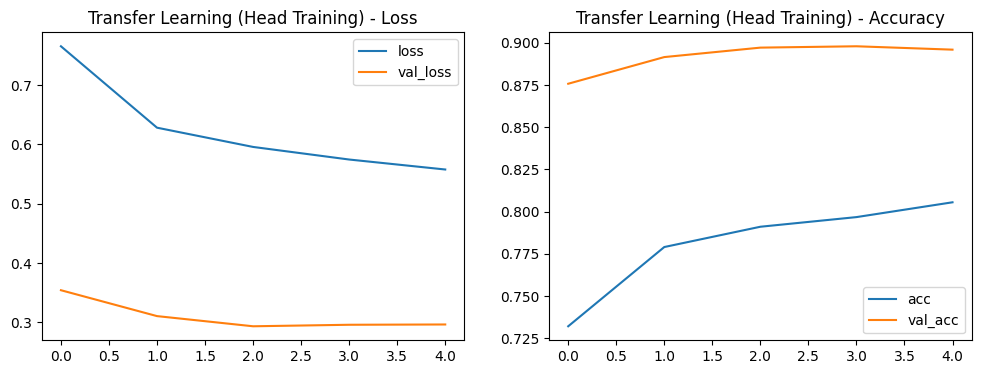

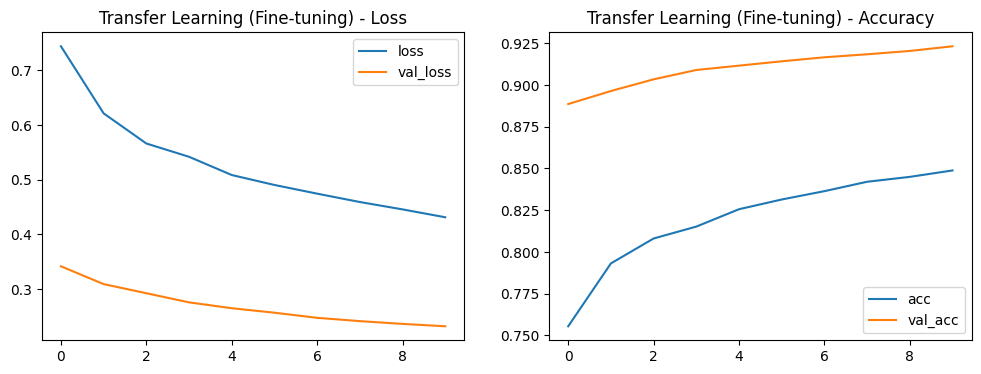

In [19]:
def plot_history(h, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.show()

plot_history(history_head, "Transfer Learning (Head Training)")
plot_history(history_ft, "Transfer Learning (Fine-tuning)")

현저히 높아진 Accuracy 와 낮은 Loss 확인 가능.

Saved Models:

In [ ]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_ft.save(os.path.join(save_dir, "effnetb0_finetune_cifar10.keras"))

# 로드 예시
model_ft_loaded = keras.models.load_model(os.path.join(save_dir, "effnetb0_finetune_cifar10.keras"))
print("Loaded model:", model_ft_loaded.name)